In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from tqdm import tqdm

In [2]:
# read data
data = pd.read_csv("Returns.csv")
# set Date as index
data.set_index("Date",inplace=True)

In [3]:
#get the dates to look at the data
#convert the index to datetime
data.index = pd.to_datetime(data.index)
#delete the days and keep only the year
#data.index = data.index.year
#show
#data.head()

In [4]:
# specify stocks that can be included, feel free to add more
df = data[["GS","MSFT","AAPL","V","VZ","NKE"]].copy()
#convert the data to percent
df = df*0.01

In [5]:
# calculate following properties of the specified stocks:
# hint: just save the results in numpy arrays
# 1. expected annual mean returns (mus)
#get the monthly mean for all columns and safe it in a numpy array
mus = df.mean().to_numpy()
#get the annual mean by potenicing the monthly mean with 12
mus = np.power(mus+1,12)-1
# 2. covariance matrix of monthly stock returns (sigma)
sigma = np.cov(df.T)
# hint:  there is a helpful numpy function



In [6]:
# calculate the annual mean risk free rate from the given monthly data
float_rF = data["MonthlyRiskFreeRate"].mean()

You will need to calculate the portfolio risk and return very often in the coming tasks. It makes sense to define functions for that:
- Define a function that takes the weights and the cov-matrix as input and returns the portfolio risk (volatility).
- Define a function that uses the weights and expected returns as inputs and returns the portfolio return.

For matrix multiplication, see numpy.matmul

In [7]:
# declare functions to caluclate:

# 1. portfolio risk (with inputs "weights" and "sigma")
def portfolio_risk(weights,sigma):
    #quadrate the weights
    #weights_2 = np.power(weights,2)
    #calulate a 1D numpy matrix with the main diagonal of sigam
    #sigma_diag = [sigma[i][i] for i in range(len(sigma))].to_numpy()
    #calculate the portfolio risk
    #portfolio_risk = np.dot(weights_2,sigma_diag) 
    #calculate the second part of the portfolio risk
    #sum_2 = 0
    #for i in range(0,len(weights)):
    #    for j in range(i,len(weights)):
    #        sum_2 = sum_2 + weights[i]*weights[j]*sigma[i][j]
    #portfolio_risk = portfolio_risk + 2*sum_2
    portfolio_risk = np.dot(weights.T,np.dot(sigma,weights))
    #return the portfolio risk
    return portfolio_risk
# 2. portfolio return (with inputs "weights" and "mus")
def portfolios_return(weights,mus):
    #calculate the portfolio return
    portfolio_return = np.dot(weights,mus)
    #return the portfolio return
    return portfolio_return




# Monte Carlo Simulation
To find efficient portfolios and determine the efficient frontier, we first try a brute-force approach with a monte-carlo simulation technique. We simulate portfolio weights randomly and determine the risk and return structure in the hope of also finding the most efficient ones.

**Tasks**
- Simulate 100.000 portfolios with randomly generated weights, calculate the return, risk and sharpe ratio.
- Out of the simulated portfolios, find the one with the highest sharpe ratio and the minimum-variance portfolio.
- Plot all the portfolios and highlight the two from the task above.

In [16]:
### simulate portfolios with randomly generated weights

num_portfolios = 10000  # amount of portfolios

# use this to save the simulated data (return, risk, sharpe ratio)
results = np.zeros((3,num_portfolios))

# use this to track your weights
weights_record = []


# now simulate random weights and calculate portfolio risk, return and sharpe ratio
for i in range(num_portfolios):
    # generate random weights
    weights = np.random.random(len(df.columns))
    # normalize them
    weights /= np.sum(weights)
    # save them
    weights_record.append(weights)
    # calculate portfolio risk
    portfolio_risk_i = portfolio_risk(weights,sigma)
    # calculate portfolio return
    portfolio_return_i = portfolios_return(weights,mus)
    # calculate portfolio sharpe ratio
    portfolio_sharpe_ratio_i = ((portfolio_return_i-float_rF)/portfolio_risk_i)*0.01
    # save results
    results[0,i] = portfolio_risk_i
    results[1,i] = portfolio_return_i
    results[2,i] = portfolio_sharpe_ratio_i



In [17]:
# 1. find the portfolio with max sharpe ratio
# create variables to save return and risk of that portfolio (for plotting, later)
# save the weights in an extra dataframe
#convert results to a dataframe
results_df = pd.DataFrame(results.T,columns=["risk","return","sharpe"])
weights_max =results_df[ results_df["sharpe"] == results_df["sharpe"].max()].copy()


# 2. find the minimum variance portfolio
# save also return, risk and weights
weights_min =results_df[ results_df["risk"] == results_df["risk"].min()].copy()


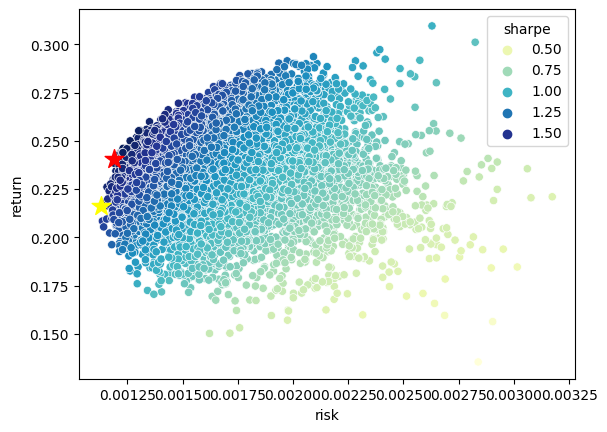

In [18]:
# now, let's plot everything
# hint: use the parameter cmap of the matplotlib scatter plot
# for a clearer view try to change the marker size and alpha value
#plot the results in a scatterplot
sns.scatterplot(x=results_df["risk"],y=results_df["return"],hue=results_df["sharpe"],palette="YlGnBu")
#mark the point with the highest expected return und the point withe the minimal risk
plt.scatter(weights_max["risk"],weights_max["return"],marker="*",color="red",s=200)
plt.scatter(weights_min["risk"],weights_min["return"],marker="*",color="yellow",s=200)


# Optimization
The Monte-Carlo method with enough simulations will surely produce good results, but it is not an efficient method to determine the optimal portfolios for every targeted return. We can use an optimisation solver to minimize the risk function instead (see scipy.optimize.minimize).

**Tasks**:
- Define the range of possible returns.
- Set up the function and constraints for the optimization program
- For every possible return, find the efficient portfolio with minimal risk with the optimization program.
- Plot the resulting efficient frontier
- Find the portfolio with max sharpe ratio (tangency portfolio)

In [19]:
# pre-define parameters
efficients = []

# define the number of assets
num_assets =  len(df.columns)

# define bounds for the weights
bounds = tuple((0,1) for asset in range(num_assets))



# define the range of possible returns
# hint: use a numpy array with step size 0.0001
range_possible_returns = np.arange(results_df["return"].min(),results_df["return"].max(),.0001)


In [20]:
# define an initial guess (portfolio with equal weights for all stocks in an array)
init_guess = np.full((num_assets),1/num_assets) 

# set the constraints for the optimization program
# hint: the constraints are defined as a list of python dictionaries
# hint: define the function for it to equal = 0
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }, 
               {'type': 'eq', 'fun': lambda x: portfolios_return(x,mus) - i   }]

# for every possible return in the defined range, run the optimisation
# define loop
for i in tqdm(range_possible_returns):
    # run the optimisation
    # hint: you have previously defined the function already
    result = minimize(portfolio_risk,init_guess , args=sigma, method='SLSQP', bounds=bounds, constraints=constraints)

    # save the results for the efficient portfolios in the efficients array
    efficients.append(result)
    #clear the bar from tqdm
    tqdm._instances.clear()
    




100%|██████████| 1741/1741 [00:21<00:00, 80.35it/s] 


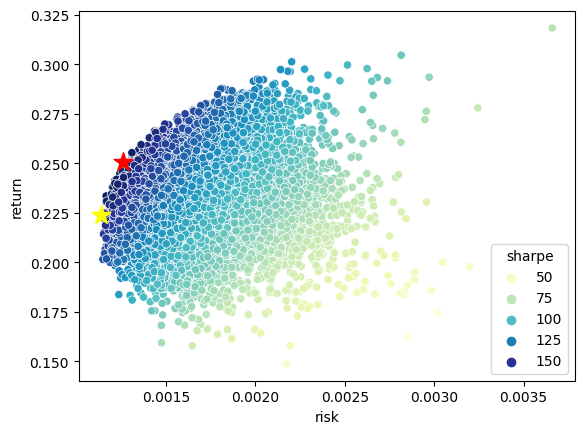

In [13]:
# Add to the previous scatter plot your calculated efficient frontier
# as well as the newly determined minimum variance portfolio and max sharpe ratio portfolio
#plot the results in a scatterplot
sns.scatterplot(x=results_df["risk"],y=results_df["return"],hue=results_df["sharpe"],palette="YlGnBu")
#mark the point with the highest expected return und the point withe the minimal risk
plt.scatter(weights_max["risk"],weights_max["return"],marker="*",color="red",s=200)
plt.scatter(weights_min["risk"],weights_min["return"],marker="*",color="yellow",s=200)
#plot the efficient frontier



In [14]:
# From the efficient portfolios, find the portfolio with max sharpe ratio (tangency portfolio)
# hint: the optimisation returns the function value in the dictionary entry "fun" of the efficients variable

In [15]:
# Show the portfolio with the max Sharpe Ratio determined by the optimisation